# Ejercicio: Spectral clustering para documentos

El clustering espectral es una técnica de agrupamiento basada en la topología de gráficas. Es especialmente útil cuando los datos no son convexos o cuando se trabaja, directamente, con estructuras de grafos.

##Preparación d elos documentos

Trabajaremos con documentos textuales. Estos se limpiarán y se convertirán en vectores. Posteriormente, podremos aplicar el método de spectral clustering.

In [0]:
#Se importan las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

La librería de Natural Language Toolkit (nltk) proporciona algunos corpus con los que se puede trabajar. Por ejemplo, el cropus Gutenberg (https://web.eecs.umich.edu/~lahiri/gutenberg_dataset.html) del que usaremos algunos datos. Asimismo, obtendremos de esta librería herramientas de preprocesamiento: stemmer y lista de stopwords.

In [0]:
import nltk
#Descarga del corpus
nltk.download('gutenberg')
#Descarga de la lista de stopwords
nltk.download('stopwords')

from nltk.corpus import gutenberg
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Definimos los nombres de los archivos (ids) y la lista de paro

In [0]:
#Obtiene ids de los archivos del corpus gutenberg
doc_labels = gutenberg.fileids()

#Lista de stopwords para inglés
lista_paro = stopwords.words('english')

Definiremos una función que se encargará de preprocesar los textos. Se eliminan símbolos, se quitan elementos de la lista de stopwords y se pasa todo a minúsculas.

In [0]:
def preprocess(document):
  #Lista que guarda  archivos limpios
  text = []
  for word in document:
    #Minúsculas
    word = word.lower()
    #Elimina stopwords y símbolos
    if word not in lista_paro and word.isalpha() == True:
      #Se aplica stemming
      text.append(PorterStemmer().stem(word))
  return text

Por cada documento, obtenemos la lista de sus palabras (stems) aplicando un preprocesado. Cada documento, entonces, es de la forma $d_i = \{w_1, w_2, ..., w_{N_i}\}$, donde $w_k$ son los stems del documento.

In [0]:
docs = []
for doc in doc_labels:
  #Lista de palabras del documentos
  arx = gutenberg.words(doc)
  #Aplica la función de preprocesado
  arx_prep = preprocess(arx)
  docs.append(arx_prep)
  #Imprime el nombre del documento, su longitud original y su longitud con preproceso
  print(doc,len(arx), len(arx_prep))

austen-emma.txt 192427 73149
austen-persuasion.txt 98171 38337
austen-sense.txt 141576 53986
bible-kjv.txt 1010654 374945
blake-poems.txt 8354 3805
bryant-stories.txt 55563 21718
burgess-busterbrown.txt 18963 7582
carroll-alice.txt 34110 12240
chesterton-ball.txt 96996 39715
chesterton-brown.txt 86063 35348
chesterton-thursday.txt 69213 28328
edgeworth-parents.txt 210663 78148
melville-moby_dick.txt 260819 110459
milton-paradise.txt 96825 45568
shakespeare-caesar.txt 25833 11056
shakespeare-hamlet.txt 37360 15898
shakespeare-macbeth.txt 23140 10078
whitman-leaves.txt 154883 65080


Posteriormente, convertiremos cada documento en un vector en $\mathbb{R}^d$. Para esto, utilizaremos el algoritmo Doc2Vec.

In [0]:
#Dimensión de los vectores
dim = 300
#tamaño de la ventana de contexto
windows_siz = 15

#Indexa los documentos con valores enteros
documents = [TaggedDocument(doc_i, [i]) for i, doc_i in enumerate(docs)]
#Aplica el modelo de Doc2Vec
model = Doc2Vec(documents, vector_size=dim, window=windows_siz, min_count=1)

#Matriz de datos
X = np.zeros((len(doc_labels),dim))
for j in range(0,len(doc_labels)):
  #Crea la matriz con los vectores de Doc2Vec
  X[j] = model.docvecs[j]
  
print(X)

[[-0.71790749  0.52590156  0.04665314 ... -1.11765587  0.27269235
   0.17521498]
 [-0.99053538  0.81888688  0.08494744 ... -1.4580884   0.35552233
   0.36190808]
 [-1.1343857   0.89900047  0.07679608 ... -1.67795575  0.4307873
   0.40497407]
 ...
 [-1.57137489  1.01522303  0.13583013 ... -2.54420257  0.6712212
   0.23293038]
 [-1.57902765  1.01099396  0.12562202 ... -2.54485178  0.67597187
   0.24470329]
 [-0.93969488  0.65869391  0.03659648 ... -1.44744205  0.37233579
   0.26923421]]


###Visualización

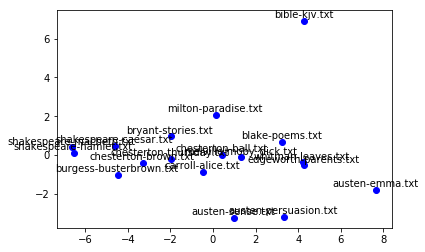

In [0]:
#Función para plotear
def plot_words(Z,ids,color='blue'):
    #Reduce a dos dimensiones con PCA
    Z = PCA(n_components=2).fit_transform(Z)
    r=0
    #Plotea las dimensiones
    plt.scatter(Z[:,0],Z[:,1], marker='o', c=color)
    for label,x,y in zip(ids, Z[:,0], Z[:,1]):
        #Agrega las etiquetas
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

plot_words(X, doc_labels)
plt.show()

##Aplicación de spectral clustering

Ahora se debe aplicar el algoritmo de spectral clustering a estos datos. Como hemos visto, se debe tomar en cuenta diferentes criterios:

* La función graph kernel se va utilizar
* El método de selección de vecinos (fully connected, k-nn)
* El número de dimensiones que queremos obtener
* El número de clusters en k-means

Pruebe con estos parámetros para obtener un buen agrupamiento de los documentos elegidos. 